# Building Nemotron-CC data curation pipeline using Nemo Curator

This tutorial demonstrates how to build Nemotron-CC data curation pipeline (https://arxiv.org/pdf/2412.02595) using NeMo Curator. The NeMo Curator is a Python library that consists of a collection of scalable data-mining modules for curating natural language processing (NLP) data for training large language models (LLMs). It consists of easy to use modules for data download, extraction, language identification, quality filtering, deduplication to build high-quality data curation pipelines at scale from massive uncurated web corpora.

## Nemotron-cc curation pipeline components

- Common Crawl data download and extraction
- Language Identification and filtering
- Exact and fuzzy deduplication
- Heuristic filtering and Perplexity filtering
- Model based quality labeling
- Postprocessing

## Flowchart

# <img src="nemotron_cc_diagram.png" alt="Nemotron-CC Diagram" width="800"/>


In [30]:
# Display each individual phases in the flow chart
# !pip install mermaid-python
from mermaid import Mermaid

with open("flowchart.txt", "r") as f:
    mermaid_code = f.read()

# Create and display the diagram
Mermaid(mermaid_code)

## Prerequisites

### System Requirements
Here is the hardware setting for this notebook

**GPU**: NVIDIA A100 80GiB.

**CUDA & Nvidia Drivers**: CUDA 12.2 with Driver 535.154.05

**OS**: ubuntu 22.04

### Getting NeMo Framework Training Container
- Get access to the container via https://developer.nvidia.com/nemo-framework
- Set your docker credentials 
    ```bash
    docker login nvcr.io

    Username: $oauthtoken
    Password: <Your NGC Key>
- Get NeMo NeMo Framework Training Container
    ```bash
    docker pull nvcr.io/nvidia/nemo:25.05.rc2


## 0. Env Setup

In [1]:
!pip install jsonlines

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_

In [1]:
%env CUDA_VISIBLE_DEVICES 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os

from nemo_curator.utils.distributed_utils import get_client, get_num_workers
from nemo_curator.utils.file_utils import get_all_files_paths_under, separate_by_metadata
from nemo_curator.utils.distributed_utils import read_data, write_to_disk
from nemo_curator.datasets import DocumentDataset
from helper import DataSizeTracker

import pandas as pd
import time
import cudf
import dask_cudf
import dask
import numpy as np
from dask.distributed import Client, LocalCluster
import jsonlines

In [3]:
def pre_imports():
    import cudf 

def check_jsonl_file(file_dir):
    for file in os.listdir(file_dir):
        if 'jsonl' not in file:
            continue
        with open(os.path.join(file_dir,file), 'r', encoding='utf-8') as f:
            first_line = f.readline()
            print(first_line)
        break

def extract_lines_with_id(file_path,target_list):
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            if obj.get('id') in target_list:
                yield obj

def get_base_dataset_file_name(download_folder):
    files = os.listdir(download_folder)
    for file in files:
        if file.startswith('thwiki') and file.endswith(''):
            return file

In [4]:
cur_dir = os.getcwd()
print(cur_dir)
data_dir = f"{cur_dir}/data/"

/workspace/nemotron-cc


## 1. Data extraction and preprocessing

We will download only two snapshots of common crawl dataset, however the code works for any number of snapshots. We will use JustText and Trafilatura for extraction and FasttextLid for langauge identification.

### 1.1 Download and extraction

In [8]:
from nemo_curator.download import download_common_crawl

 Start a CPU based Dask cluster. Please modify `n_workers` and `memory_limit` according to your hardware specification. To process TH wikipedia data, it's advised to have `memory_limit` greater than 12GB

In [9]:
client = get_client(cluster_type="cpu", n_workers=10, processes=True, memory_limit='16GiB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 160.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42307,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 160.00 GiB
Comm: tcp://127.0.0.1:37885,Total threads: 1
Dashboard: http://127.0.0.1:36173/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:38263,


In [7]:
#Output
download_base_directory= os.path.join(data_dir,"cc_crawl")
download_output_directory = os.path.join(download_base_directory,"data")

#Relevant parameters
start_snapshot = "2024-46"
end_snapshot = "2024-51"
language = 'EN'
url_limit = 10

In [ ]:
# Download and sample data
common_crawl = download_common_crawl(
    download_output_directory, 
    start_snapshot, 
    end_snapshot, 
    url_limit=url_limit,
    output_type="jsonl", # Default - "jsonl"
    algorithm=JusTextExtractor(), # Default - JusTextExtractor
).df().compute()

**[Optional]** Verify result

In [16]:
# List all the file in the output directory.
!ls {download_output_directory}

# Please replace your dataset file name accordingly.
# ! wc -l  {download_output_directory}/{YOUR DATASET FILE NAME}.jsonl

CC-MAIN-20241201162023-20241201192023-00000.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00001.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00002.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00003.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00004.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00005.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00006.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00007.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00008.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00009.warc.gz.jsonl


In [17]:
check_jsonl_file(download_output_directory)

{"text":"Создаем узнаваемость\n\nпринимаем заказы по телефону200-19-00ежедневно с 09:00 до 18:00 (без выходных)или по почте zakaz@19.uz (круглосуточно)доставим чехлы бесплатно от 2-х до 4-х днейпо будням с 10:00 до 18:00 в пределах города","language":"RUSSIAN","url":"http:\/\/19.uz\/product.php?cat=00&id=26","warc_id":"327c8605-a7dc-4496-9a74-ac394d20bcbe","source_id":"crawl-data-CC-MAIN-2024-51-segments-1733066035857.0-warc-CC-MAIN-20241201162023-20241201192023-00002.warc.gz"}



In [ ]:
!rm -r {download_output_directory}/downloads

**[Optional]** Close the Dask cluster.You might encounter error such as `Caught signal 11`.It's OK, just rerun the cell again.

In [18]:
client.cluster.close()
client.shutdown()

Now that we have the dataset, it would be great to see how each step of the pipeline impacts the size of the dataset. Don't worry we have a small helper function which tracks this for you.

In [8]:
input_dataset = DocumentDataset.read_json(download_output_directory, backend='pandas')
print("Length of downloaded and extracted dataset:", len(input_dataset))
tracker = DataSizeTracker(len(input_dataset))

Reading 10 files with blocksize='1gb' / files_per_partition=None


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:412: UserWarning: If underlying JSONL data does not have a consistent schema, reading with blocksize will fail. Please use files_per_partition approach instead.
  warnings.warn(
/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:418: UserWarning: Pandas backend with blocksize cannot read multiple JSONL files into a single partition. Please use files_per_partition if blocksize exceeds average file size.
  warnings.warn(


Length of downloaded and extracted dataset: 157106


### 1.2 Language seperation and unicode fixing

In this section, we will be using a language classification model by fasttext to separate the TH wikipedia dataset based on the document major languages, and we will also fix the unicode in the documents. Detailed steps are:

1. Download fasttext model for text language detection
2. Construct a filter which uses the downloaded fasttext model to produce a language label to each document. 
3. Separate each document by the language label. This will create sub-folders for each languages under the output path and the documents under the same language will be output to a .jsonl file in the corresponding sub-folder.
4. Load .jsonl file in the folder of desirable language. In this example, `TH` folder will be loaded.
5. Apply `UnicodeReformatter` to the data and output the result in .jsonl format. 



In [19]:
from nemo_curator import ScoreFilter, Modify
from nemo_curator.filters import FastTextLangId
from nemo_curator.modifiers import UnicodeReformatter

**[Optional]** Start a cpu based Dask cluster.

In [ ]:
# client = get_client(cluster_type="cpu", n_workers=10, processes=True, memory_limit='16GiB')
# client

Define parameters

In [9]:
# Input path
multilingual_data_path = download_output_directory

# Output path
language_base_output_path = os.path.join(data_dir,"language_sep")
language_data_output_path = os.path.join(language_base_output_path,"data")
language_separated_output_path = os.path.join(language_data_output_path,"language")
lang_sep_cleaned_data_output_path = os.path.join(language_data_output_path,"cleaned")

# Fasttext model path
model_path = language_base_output_path

# Define desired language
target_language = "EN"

# Define key in output .jsonl files to store the language information
language_field = "language"

Download fasttext model

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -P {model_path}

Apply fasttext model to separate documents by their languages

In [ ]:
t0 = time.time()

# Load dataset 
multilingual_dataset = DocumentDataset.read_json(multilingual_data_path, blocksize="64MiB", add_filename=True)

#Define Language separation pipeline
lang_filter = FastTextLangId(os.path.join(model_path,'lid.176.bin'))
language_id_pipeline = ScoreFilter(lang_filter, score_field=language_field, score_type='object')
filtered_dataset = language_id_pipeline(multilingual_dataset)

# The language separation pipeline will produce a result looks like ['EN',0.96873], we only want to keep the 'EN' label and drop the detailed classifier score
filtered_dataset.df[language_field] = filtered_dataset.df[language_field].apply(lambda score: score[1],meta = (language_field, 'object'))

# Split the dataset to corresponding language sub-folders
language_stats = separate_by_metadata(filtered_dataset.df, language_separated_output_path, metadata_field=language_field).compute()

print(f"Time taken for splitting language:{time.time()-t0}")

Load `UnicodeReformatter` to reformat any unicode appeared in the desired language dataset

In [ ]:
t0 = time.time()

# Read the language specific data and fix the unicode in it
lang_data_path = os.path.join(language_separated_output_path, target_language)
lang_data = DocumentDataset.read_json(lang_data_path, blocksize="64MiB", add_filename=True)

cleaner = Modify(UnicodeReformatter())
cleaned_data = cleaner(lang_data)

# Write the cleaned_data
cleaned_data.to_json(lang_sep_cleaned_data_output_path, write_to_filename=True)

print(f"Time taken for fixing unicode:{time.time()-t0}")

**[Optional]** Verify the result. We can see that some documents has been removed from TH wikipedia dataset since the number of lines in this output file is less than the original file 

In [21]:
# List all the file in the output directory.
! ls {lang_sep_cleaned_data_output_path}

# Please replace your dataset file name accordingly.
# ! wc -l  {lang_sep_cleaned_data_output_path}/{YOUR DATASET FILE NAME}.jsonl

CC-MAIN-20241201162023-20241201192023-00000.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00001.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00002.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00003.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00004.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00005.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00006.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00007.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00008.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00009.warc.gz.jsonl


In [22]:
check_jsonl_file(os.path.join(language_separated_output_path,'EN'))

{"language":"EN","source_id":"crawl-data-CC-MAIN-2024-51-segments-1733066035857.0-warc-CC-MAIN-20241201162023-20241201192023-00002.warc.gz","text":"Cook pasta according to package instructions. Saute ham in oil to brown it a bit and then remove from pan and set aside. Cook onion 4 minutes then add mushrooms and continue cooking another 4 minutes. Mix in flour, rosemary and pepper then gradually add milk and bring to a boil and cook 2 minutes to thicken it up. Then reduce heat and add peas and sour cream and cook 2 minutes. Mix with the drained pasta and ham and heat through.\n\nJoin us on Facebook and Get Notified When New Recipes Are Posted\n\nAbout 400 Calories or Less\n\nWhat's a foodie to do when she passes the 40 mark and her metabolism comes to a screeching halt? (hint...denial did not work !) So I've put together a collection of everyday meals that are simple to make, under 400 calories, yet so savory and delicious that you won't miss your old favorites and standbys. I've tested

In [10]:
lang_id_dataset = DocumentDataset.read_json(os.path.join(language_separated_output_path,'EN'), backend='pandas')
tracker.record_size("Language Identification", len(lang_id_dataset))
tracker.print_summary()

Reading 10 files with blocksize='1gb' / files_per_partition=None


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:412: UserWarning: If underlying JSONL data does not have a consistent schema, reading with blocksize will fail. Please use files_per_partition approach instead.
  warnings.warn(
/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:418: UserWarning: Pandas backend with blocksize cannot read multiple JSONL files into a single partition. Please use files_per_partition if blocksize exceeds average file size.
  warnings.warn(


Original Size: 157106
Language Identification: 74194, Incremental Reduction: 82912 (52.77%)
Overall Reduction: 82912 (52.77%)
Remaining dataset: 74194


**[Optional]** Close the Dask cluster.

In [ ]:
# client.cluster.close()
# client.shutdown()

## 2. Data deduplication and Quality filtering

We will perform both Exact and Fuzzy deduplication in this part of the tutorial.

In exact deduplication, the document text is hashed into unique string using certain hashing algorithm, such as 'md5'. The documents with exact hashed values are having identical text. We will output the `ID` of duplicated documents for removal later. The function used is `ExactDuplicates()`. Arguments for this function include:
- `id_field`: Key in input file for identifying document ID
- `text_field`: Key in input file which contains document text.
- `hash_method`: Hashing algorithm used. Default is `md5`
- `cache_dir`: If specified, the duplicated document IDs will be output to the `cache_dir`. Otherwise, the IDs will not be saved

Also, we are going to use GPU dask cluster to accelerate computation for deduplication (both exact and fuzzy)


Before performing deduplication, it's crucial to ensure each document in our dataset has a unique identifier. While some datasets like Common Crawl might have a `source_id` field, it's often insufficient for uniquely identifying individual records. To address this, we'll generate and assign unique IDs to each document, following the format `<prefix>_<id>`. This unified `id` field is particularly useful when working with multiple datasets, as it allows us to easily track the origin of removed documents during the deduplication process. We'll use the `AddID()` function from the NeMo Curator library to achieve this. The function's key parameters are:
- `id_field`: The field to be added to the input JSON file. If this key already exists, its value will be replaced with the generated ID.
- `id_prefix`: A prefix string to be added to the beginning of each generated ID (e.g., 'doc_id').
- `start_index`: The starting index for the ID sequence. If set to `None`, an unordered ID scheme is used for faster processing. In this notebook, we set it to 0 for easier reference and tracking.

### 2.1 Preparation

In [23]:
from nemo_curator import AddId

**[Optional]** If there is no running Dask cluster, start CPU based Dask cluster.

In [ ]:
# cluster = LocalCluster(n_workers=10, processes=True, memory_limit='16GB')
# client = Client(cluster)

In [11]:
#Input
add_id_input_data_dir = lang_sep_cleaned_data_output_path

#Output
added_id_output_path = os.path.join(data_dir,"add_id/cleaned")

#Format of output ID will be <prefix>_<id>, Define prefix here
add_ID_id_prefix="EN_CC"

In [ ]:
t0 = time.time()
# Read input files
dataset = DocumentDataset.read_json(add_id_input_data_dir,add_filename=True)

# Run AddID() on the input dataset
add_id = AddId(id_field='id',id_prefix=add_ID_id_prefix,start_index=0)
id_dataset = add_id(dataset)

#Output files
id_dataset.to_json(added_id_output_path, write_to_filename=True)

print(f"Time taken for add ID:{time.time()-t0}")

In [25]:
check_jsonl_file(added_id_output_path)

{"language":"EN","source_id":"crawl-data-CC-MAIN-2024-51-segments-1733066035857.0-warc-CC-MAIN-20241201162023-20241201192023-00002.warc.gz","text":"Cook pasta according to package instructions. Saute ham in oil to brown it a bit and then remove from pan and set aside. Cook onion 4 minutes then add mushrooms and continue cooking another 4 minutes. Mix in flour, rosemary and pepper then gradually add milk and bring to a boil and cook 2 minutes to thicken it up. Then reduce heat and add peas and sour cream and cook 2 minutes. Mix with the drained pasta and ham and heat through.\n\nJoin us on Facebook and Get Notified When New Recipes Are Posted\n\nAbout 400 Calories or Less\n\nWhat's a foodie to do when she passes the 40 mark and her metabolism comes to a screeching halt? (hint...denial did not work !) So I've put together a collection of everyday meals that are simple to make, under 400 calories, yet so savory and delicious that you won't miss your old favorites and standbys. I've tested

Close Dask cluster. This cell needs to be run as we are starting a new GPU Dask cluster in the following task

In [ ]:
# client.cluster.close()
# client.shutdown()

### 2.2 Exact deduplication

Now, lets start off with Exact Deduplication process.

In [26]:
from nemo_curator.modules import ExactDuplicates

Start a GPU based Dask cluster. Since GPU based Dask cluster involves setting several arguments, we will use the `get_client()` wrapper function to quickly set up. 

In [ ]:
client = get_client(cluster_type = 'gpu', set_torch_to_use_rmm=False)
print(f"Number of dask worker:{get_num_workers(client)}")
client.run(pre_imports)
client

If you encounter the following error
`get_client() missing 1 required positional argument: 'args'`:

This is probably because the `nemo_curator` library is not updated to the newer version. Please run the following line in the terminal, following instruction in our [GitHub](https://github.com/nicoleeeluo/NeMo-Curator/tree/main) repo, and restart the notebook. Intermediate result of the previous section has been saved to local, you can start from this section after updating.

In [ ]:
#pip install --extra-index-url https://pypi.nvidia.com ".[cuda12x]"

Define parameters

In [12]:
#Input
exact_dedup_input_dataset_dir = added_id_output_path

#Output
exact_dedup_base_output_path = os.path.join(data_dir,"exact_dedup")
exact_dedup_log_dir = os.path.join(exact_dedup_base_output_path,'log')
exact_dedup_output_dir = os.path.join(exact_dedup_base_output_path,'data')

#Parameters for ExactDuplicates()
exact_dedup_dataset_id_field = "id"
exact_dedup_dataset_text_field = "text"


In [ ]:
!mkdir -p {exact_dedup_log_dir}
!mkdir -p {exact_dedup_output_dir}

In [ ]:
t0 = time.time()
# Read input dataset
input_dataset = DocumentDataset.read_json(exact_dedup_input_dataset_dir, backend='cudf')

#Run exact deduplication to the input
exact_dup = ExactDuplicates(
    logger=exact_dedup_log_dir,
    id_field=exact_dedup_dataset_id_field,
    text_field=exact_dedup_dataset_text_field,
    hash_method="md5",
    cache_dir=exact_dedup_output_dir #Duplicated document ID list is output to the cache_dir
)
duplicates = exact_dup(dataset=input_dataset)

print(f"Number of exact duplicated file:{len(duplicates)}")

print(f"Time taken for exact duplicate:{time.time()-t0}")

**[Optional]** Verify the output duplicated ID. We can group by the `_hashes` to get the list of duplicated documents having the same _hashes and use `extract_lines_with_id()` to verify that those documents are indeed exact duplicates. Please note that the `id` might changes, therefore, please replace the `target_list` when necessary

In [ ]:
exact_dedup_res = pd.read_parquet(os.path.join(exact_dedup_output_dir,"_exact_duplicates.parquet"))
print(f"Number of exact duplicated document:{len(exact_dedup_res)}")
exact_dedup_res.head()

In [ ]:
duplicated_list = exact_dedup_res.groupby('_hashes')['id'].agg(list).reset_index().head()
duplicated_list

Using the duplicated id shown above, check the content to see if it's exact duplicates

In [ ]:
# example_duplicates = duplicated_list["id"].to_list()[0][0:4]

# for line in extract_lines_with_id(os.path.join(exact_dedup_input_dataset_dir,'{YOUR DATASET FILE NAME}'),example_duplicates):
#     print(line)

**[Optional]** You might choose to close Dask cluster here

In [ ]:
# client.cluster.close()
# client.shutdown()

### 2.3 Fuzzy deduplication

Now, lets perform Fuzzy Deduplication.

Fuzzy deduplication involves 3 to 5 intermediate steps to generate duplicates. Refer to https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/gpudeduplication.html for details.

Fuzzy deduplication in this example is a GPU implementation of MinhashLSH algorithm. This algorithm measures similarity based on statistics but not semantic meanings of text. There are a few concepts to be introduced before heading into fuzzy deduplication.

This algorithm has following steps in a high-level:
1. Compute minhash for each document.
2. Run Locality Sensitive Hashing (LSH) based on the minhash which further assign buckets to each document. Each document will be assigned to multiple buckets. Documents within the same bucket are deemed to be similar.
3. **[Optional]**: Run pair-wise Jaccard similarity within documents in each bucket to remove false positive cases within the buckets.
4. Based on the Buckets and jaccard values between documents (if computed), transform documents across buckets (deemed similar) into a graph and run the connected components algorithm. For a group of connected components in the graph, they are the final similar document groups and the IDs within each groups will be output for duplicate removal.
More detailed explanation please refer to https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/gpudeduplication.html#fuzzy-deduplication.

In this section, we will use the fuzzy deduplication wrapper offered by NeMo curator instead of running each step individually.

**If there is not running Dask cluster, start a GPU Dask cluster here**

In [ ]:
# client = get_client(cluster_type = 'gpu', set_torch_to_use_rmm=False)
# print(f"Number of dask worker:{get_num_workers(client)}")
# client.run(pre_imports)

In [27]:
from nemo_curator import FuzzyDuplicates, FuzzyDuplicatesConfig

In [13]:
#Input
fuzzy_dedup_data_path = added_id_output_path
#Output
fuzzy_dedup_base_output_path = os.path.join(data_dir,"fuzzy_wrapper")
fuzzy_dedup_log_dir = os.path.join(fuzzy_dedup_base_output_path,'log')
fuzzy_dedup_no_false_positive_cache_dir = os.path.join(fuzzy_dedup_base_output_path,'cache_nofp')
fuzzy_dedup_false_positive_cache_dir = os.path.join(fuzzy_dedup_base_output_path,'cache_fp')
fuzzy_dedup_output_dir = os.path.join(fuzzy_dedup_base_output_path,'data')
#Specify dataset name
dataset_name = 'EN_CC'

#Relevant parameters
id_field = 'id'
text_field = 'text'
filetype = "parquet"

!mkdir -p {fuzzy_dedup_base_output_path}
!mkdir -p {fuzzy_dedup_log_dir}
!mkdir -p {fuzzy_dedup_no_false_positive_cache_dir}
!mkdir -p {fuzzy_dedup_false_positive_cache_dir}
!mkdir -p {fuzzy_dedup_output_dir}

**[Optional]** If the cache folder is not empty, please CLEAR the folder before proceeding

In [ ]:
# !rm -r {fuzzy_dedup_no_false_positive_cache_dir}

In [ ]:
t0 = time.time()

input_dataset = DocumentDataset.read_json(fuzzy_dedup_data_path, backend='cudf')

fuzzy_dedup_config = FuzzyDuplicatesConfig(
    cache_dir=fuzzy_dedup_no_false_positive_cache_dir,
    id_field=id_field,
    text_field=text_field,
    seed=10,
    char_ngrams=24,
    num_buckets=20,
    hashes_per_bucket=13,
    use_64_bit_hash=False,
    buckets_per_shuffle=5,
    false_positive_check=False,
)

fuzzy_dup = FuzzyDuplicates(logger=fuzzy_dedup_log_dir, config=fuzzy_dedup_config)
duplicates = fuzzy_dup(dataset=input_dataset)

duplicates.to_parquet(fuzzy_dedup_output_dir, write_to_filename=False)

print(f"Time taken for Fuzzy Deduplication (No False Positive Check): {time.time()-t0} s")


In [29]:
fuzzy_dedup_res = pd.read_parquet(fuzzy_dedup_output_dir)
fuzzy_dedup_res.head()

,group,id
0,6872,EN_CC-0000066724
1,10232,EN_CC-0000006501
2,6874,EN_CC-0000019908
3,10234,EN_CC-0000047960
4,2872,EN_CC-0000004459


This section removes duplicate documents identified by exact and fuzzy deduplication. It loads the deduplication results and the input dataset, then removes the identified duplicates using DataFrame operations.

Define parameters

In [14]:
#Input
dataset_dir = added_id_output_path

#Output
dudped_output_dir = os.path.join(data_dir,"remove_duplicate/result.parquet")

#Relevant parameters
input_id_field = 'id'
id_prefix = add_ID_id_prefix

!mkdir -p {dudped_output_dir}

We will first process the result of exact deduplication. Since result of exact deduplication contains original ID used in input dataset, it is more straightforward to deal with.

In [ ]:
#Load .jsonl dataset
input_dataset = DocumentDataset.read_json(dataset_dir, backend='cudf')

#Load exact deduplicate result and extract list of duplicated document ID
exact_duplicates = DocumentDataset.read_parquet(os.path.join(exact_dedup_output_dir,"_exact_duplicates.parquet"), backend='cudf')
exact_docs_to_remove = exact_duplicates.df.map_partitions(
    lambda x: x[x._hashes.duplicated(keep="first")]
)

#Remove the duplicated document from input dataset
result = input_dataset.df[
    ~input_dataset.df[input_id_field].isin(exact_docs_to_remove[input_id_field].compute())
]

In [ ]:
#Loads result from fuzzy dedup wrapper
fuzzy_duplicates = pd.read_parquet(fuzzy_dedup_output_dir)

#Generate list of near duplicate document ID
fuzzy_docs_to_remove = fuzzy_duplicates[fuzzy_duplicates.duplicated(subset=['group'], keep='first')]

In [ ]:
#Remove near duplicates
result = result[~result[input_id_field].isin(fuzzy_docs_to_remove[input_id_field])]

#Save final result to local
result.to_parquet(dudped_output_dir, write_to_filename=True)

Verify the result of duplicate removal. We can see that the number of document in resultant document is less than the original dataset 

In [15]:
res = pd.read_parquet(dudped_output_dir)
tracker.record_size("Exact and Fuzzy deduplication", len(res))
tracker.print_summary()

Original Size: 157106
Language Identification: 74194, Incremental Reduction: 82912 (52.77%)
Exact and Fuzzy deduplication: 62984, Incremental Reduction: 11210 (15.11%)
Overall Reduction: 94122 (59.91%)
Remaining dataset: 62984


Close the GPU Dask Cluster.You might encounter error such as `Caught signal 11`.It's OK, just rerun the cell again.

In [ ]:
client.cluster.close()
client.shutdown()

### 2.4 Heuristic and Perplexity Fitlering

In this section, we will apply multiple heuristic filters to the dataset, record the heuristic score for documents and documents removed for each filter. For each heuristic filter, the filter calculates a quality scores based on user defined heuristics/algorithms and classifies documents into high quality documents or low quality documents if the quality score is above the user defined threshold.

For detailed implementation and description of each heuristic filter, please refer to `./NeMo-Curator/nemo-curator/filters/heuristics_filter.py`. For customized heuristic filter implementation, user shall follow the sample implementations, write customized filters and update the .yaml files accordingly.

In [16]:
from nemo_curator.utils.config_utils import build_filter_pipeline
from nemo_curator import Score, ScoreFilter
from nemo_curator.utils.file_utils import expand_outdir_and_mkdir

**[Optional]** The following cell is to remove warning from dask.

In [ ]:
import warnings

# Disable the metadata warning
warnings.filterwarnings("ignore", module="dask.dataframe.core")

Create a CPU Dask Cluster.

In [ ]:
client = get_client(cluster_type="cpu", n_workers=10, processes=True, memory_limit='16GiB')
client

Define some helper functions

In [41]:
def get_dataframe_complement(original_df, filtered_df):
    def partition_complement(part_original_df, partition_info=None):
        if not partition_info:
            return part_original_df
        part_filtered_df = filtered_df.get_partition(partition_info["number"])
        complement_mask = ~part_original_df.index.isin(part_filtered_df.index.persist())
        complement_df = part_original_df[complement_mask]
        return complement_df

    return original_df.map_partitions(partition_complement)

def write_scores(df, output_dir):
    for column in df.columns:
        output_path = os.path.join(output_dir, f"{column}.txt")
        df[column].to_csv(output_path, single_file=True, encoding="utf-8", header=False, index=False, mode="a")

def get_score_fields(pipeline):
    score_fields = []
    for nc_module in pipeline.modules:
        if isinstance(nc_module, Score) or isinstance(nc_module, ScoreFilter):
            if nc_module.score_field:
                score_fields.append(nc_module.score_field)
    return score_fields

Define parameters

In [17]:
#Input
HF_input_data_dir = dudped_output_dir
input_file_type = 'parquet'
batch_size = 1

#Output
HF_base_output_path = os.path.join(data_dir,'heuristic_filtering')
kept_document_dir =  os.path.join(HF_base_output_path,'data','hq.parquet')
removed_document_dir =  os.path.join(HF_base_output_path,'data','lq.parquet')
output_document_score_dir =  os.path.join(HF_base_output_path,'data','score')
output_file_type = 'parquet'

#Relevant parameters
filter_config_file = './config/heuristic_filter_en.yaml'
input_id_field = 'id'

!mkdir -p {kept_document_dir}
!mkdir -p {removed_document_dir}
!mkdir -p {output_document_score_dir}

Run heuristic filtering

In [ ]:
t0 = time.time()

#Load filters from config
filter_pipeline = build_filter_pipeline(filter_config_file)
score_fields = get_score_fields(filter_pipeline)

# Load dataset
dataset = DocumentDataset.read_parquet(HF_input_data_dir, files_per_partition=1, blocksize=None, backend='pandas', add_filename=True)

filtered_dataset = filter_pipeline(dataset)

# Write scores of retained doucment to separate directory
output_df = filtered_dataset.df[[input_id_field, *score_fields]]
write_scores(output_df, output_document_score_dir)

# Remove scores from dataset df
filtered_dataset = DocumentDataset(filtered_dataset.df.drop(columns=score_fields))

# Output filtered dataset
filtered_dataset.to_parquet(kept_document_dir, write_to_filename=True)

print(f"Time taken for Heuristic filtering: {time.time()-t0} s")

**[Optional]** Verify the result.

In [18]:
res = pd.read_parquet(kept_document_dir)
res.head()

,id,language,source_id,text,url,warc_id
0,EN_CC-0000000000,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Media coverage\n\nParallels Coming to the 2014...,http://028zq.com/news/shownews.php?id=16&lang=en,deee4ce0-c404-4ff3-8700-0b45e8ac6b5e
1,EN_CC-0000000001,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,techspace-skywatch\n\nA network of Autonomous ...,http://2014.spaceappschallenge.org/project/tec...,6c17be7f-7253-4703-aead-0aa6e53bcb5d
2,EN_CC-0000000002,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,lemon rosemary chicken\n\nLeave a Reply\n\nJoi...,http://400caloriesorless.com/?attachment_id=3867,f70dc315-8ee5-4cd1-b685-975f36f15e90
3,EN_CC-0000000004,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Teen Patti Master – Update APK Download & Get ...,http://789mgmslots.com/2024/08/26/teen-patti-m...,48640b9c-d821-4c3a-bf31-a16e3eb30f0f
4,EN_CC-0000000005,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Lump sum payment specialists since 1992\n\nFor...,http://GRANOFFENTERPRISES.COM/,da02f4d5-57bb-4dde-9089-cacb273d2362


In [19]:
tracker.record_size("Heuristic Filtering", len(res))
tracker.print_summary()

Original Size: 157106
Language Identification: 74194, Incremental Reduction: 82912 (52.77%)
Exact and Fuzzy deduplication: 62984, Incremental Reduction: 11210 (15.11%)
Heuristic Filtering: 47107, Incremental Reduction: 15877 (25.21%)
Overall Reduction: 109999 (70.02%)
Remaining dataset: 47107


Close the CPU Dask Cluster

In [ ]:
client.cluster.close()
client.shutdown()

Now, let's perform perplexity filtering using a KenLM model trained on wikipedia data. NeMo Curator does not support KenLM filtering out of the box, instead we will use pre-trained KenLM models hosted on HuggingFace (https://huggingface.co/edugp/kenlm/tree/main/wikipedia) to generate perplexity scores for every document and filter based on a threshold.

In [3]:
# Install dependencies
!pip install sentencepiece https://github.com/kpu/kenlm/archive/master.zip

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_

In [21]:
models_dir = os.path.join(cur_dir, "models", "wikipedia")
os.makedirs(models_dir, exist_ok=True)
# Download KenLM pre-trained models
# !wget https://huggingface.co/edugp/kenlm/blob/main/wikipedia/en.arpa.bin -P {models_dir}
# !wget https://huggingface.co/edugp/kenlm/blob/main/wikipedia/en.sp.model -P {models_dir}
# !wget https://huggingface.co/edugp/kenlm/blob/main/wikipedia/en.sp.vocab -P {models_dir}

In [38]:
from nemo_curator.filters.doc_filter import DocumentFilter
from kenlm_utility import KenlmModel

class PerplexityFilter(DocumentFilter):

  def __init__(self, threshold):
    self._kenlm_model = KenlmModel(model_path=models_dir, language="en")
    self._threshold = threshold

  def score_document(self, text: str):
    return self._kenlm_model.get_perplexity(text, normalize=True)

  def keep_document(self, score: int):
    return score <= self._threshold

In [53]:
client = get_client(cluster_type="cpu", n_workers=10, processes=True, memory_limit='16GiB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 160.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38441,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 160.00 GiB
Comm: tcp://127.0.0.1:38775,Total threads: 1
Dashboard: http://127.0.0.1:39741/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:43753,


In [58]:
#Input
PF_input_data_dir = os.path.join("/workspace/nemotron-cc/data/heuristic_filtering/data/hq.parquet",'result.parquet')
input_file_type = 'parquet'
batch_size = 1

#Output
PF_base_output_path = os.path.join(data_dir,'perplexity_filtering')
kept_document_dir =  os.path.join(PF_base_output_path,'data','hq.parquet')
removed_document_dir =  os.path.join(PF_base_output_path,'data','lq.parquet')
output_document_score_dir =  os.path.join(PF_base_output_path,'data','score')
output_file_type = 'parquet'

#Relevant parameters
input_id_field = 'id'
# Adjust the threshold to control the strictness of filtering; higher values are more lenient, lower values are more strict.
# Experiment to find the optimal balance between data reduction and quality retention.
threshold = 100000.00

!mkdir -p {kept_document_dir}
!mkdir -p {removed_document_dir}
!mkdir -p {output_document_score_dir}

In [61]:
t0 = time.time()

# Load dataset
dataset = DocumentDataset.read_parquet(PF_input_data_dir, files_per_partition=1, blocksize=None, backend='pandas', add_filename=True)

perplexity_filter = ScoreFilter(
                PerplexityFilter(threshold=100000.00),
                text_field="text",
                score_field="perplexity_score",
            )

filtered_dataset = perplexity_filter(dataset)

# Write scores of retained doucment to separate directory
output_df = filtered_dataset.df[[input_id_field, perplexity_filter.score_field]]
write_scores(output_df, output_document_score_dir)

# Remove scores from dataset df
filtered_dataset = DocumentDataset(filtered_dataset.df.drop(columns=perplexity_filter.score_field))

# Output filtered dataset
filtered_dataset.to_parquet(kept_document_dir, write_to_filename=True)

print(f"Time taken for Perplexity filtering: {time.time()-t0} s")

Reading 1 files with blocksize=None / files_per_partition=1


/usr/local/lib/python3.12/dist-packages/dask_expr/_collection.py:4376: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('text', 'float64'))

  warnings.warn(meta_warning(meta))


Writing to disk complete for 1 partition(s)
Time taken for Perplexity filtering: 283.00895953178406 s


In [51]:
res = pd.read_parquet(kept_document_dir)
tracker.record_size("Perplexity filtering", len(res))
tracker.print_summary()
len(res)

Original Size: 157106
Language Identification: 74194, Incremental Reduction: 82912 (52.77%)
Exact and Fuzzy deduplication: 62984, Incremental Reduction: 11210 (15.11%)
Heuristic Filtering: 47107, Incremental Reduction: 15877 (25.21%)
Perplexity filtering: 47107, Incremental Reduction: 0 (0.00%)
Overall Reduction: 109999 (70.02%)
Remaining dataset: 47107


47107

As you may have noticed, perplexity filtering did not further filter any documents. This is likely because the chosen threshold was too lenient for our already filtered dataset. We can further verify this by plotting a Gaussian curve of all the scores we saved during our filtering process. The plot reveals that the perplexity scores for nearly all texts are below 6000, with the majority falling below 1000. This indicates that the input dataset to this filter was already of relatively high quality. Generally, KenLM perplexity scores below 2000 are considered good, while scores above approximately 10000 are considered poor.

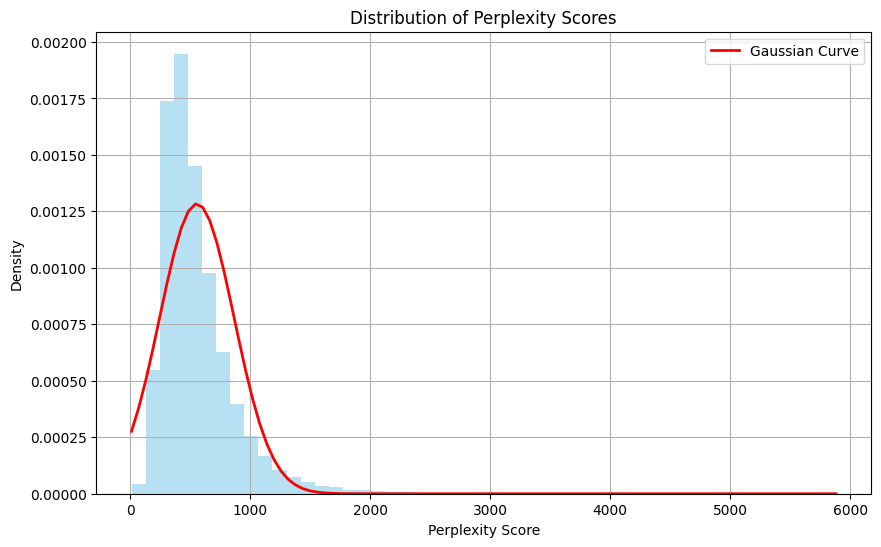

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load perplexity scores from the text file
file_path = os.path.join(output_document_score_dir, perplexity_filter.score_field + ".txt")
try:
    with open(file_path, 'r') as f:
        perplexity_scores = [float(line.strip()) for line in f]
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    perplexity_scores = []  # Assign an empty list to avoid errors later
except ValueError:
    print(f"Error: Could not convert lines in {file_path} to float. Check the file format.")
    perplexity_scores = []

if perplexity_scores:
    # Create a pandas Series from the perplexity scores
    perplexity_series = pd.Series(perplexity_scores)

    # Plot the distribution as a histogram with a Gaussian curve overlay
    plt.figure(figsize=(10, 6))
    perplexity_series.hist(bins=50, density=True, alpha=0.6, color='skyblue')

    # Overlay a Gaussian curve
    mu = perplexity_series.mean()
    sigma = perplexity_series.std()
    x = np.linspace(perplexity_series.min(), perplexity_series.max(), 100)
    plt.plot(x, (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2), color='red', linewidth=2, label='Gaussian Curve')

    plt.title('Distribution of Perplexity Scores')
    plt.xlabel('Perplexity Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No perplexity scores to plot.")


In [43]:
client.cluster.close()
client.shutdown()

### 2.5 Model based quality labeling

Now, we will assess the quality of each document using a model-based quality labeling approach. This involves classifying data into distinct quality buckets based on an ensemble of scores from several language models: [FineWebMixtralEduClassifier](https://huggingface.co/nvidia/nemocurator-fineweb-mixtral-edu-classifier), FineWebNemotronEduClassifier [FineWebNemotronEduClassifier](https://huggingface.co/nvidia/nemocurator-fineweb-nemotron-4-edu-classifier), and fasttext-oh-eli5 [fasttext-oh-eli5](https://huggingface.co/mlfoundations/fasttext-oh-eli5).
 
Much of the code in this section is adapted from this tutorial: [NeMo Curator fineweb-edu-ensemble-classification.ipynb](https://github.com/NVIDIA/NeMo-Curator/blob/main/tutorials/distributed_data_classification/fineweb-edu-ensemble-classification.ipynb). Refer to that notebook for a more detailed explanation of the process.

#### 2.5.1 Quality classification

In [5]:
from nemo_curator.classifiers import FineWebNemotronEduClassifier, FineWebMixtralEduClassifier
from nemo_curator.utils.distributed_utils import load_object_on_worker
from nemo_curator.utils.distributed_utils import get_device_total_memory
from fast_text_classifier import FastTextQualityClassifier

In [6]:
import json
import fasttext
import pandas as pd
import cudf
import dask_cudf
import numpy as np
import cupy as cp
from pathlib import Path
from typing import Optional, Tuple, Any, Dict, List
from huggingface_hub import hf_hub_download

from nemo_curator import get_client
from nemo_curator.classifiers import FineWebNemotronEduClassifier, FineWebMixtralEduClassifier
from nemo_curator.datasets import DocumentDataset
from nemo_curator.utils.distributed_utils import load_object_on_worker
from nemo_curator.utils.distributed_utils import get_device_total_memory

In [ ]:
client = get_client(cluster_type="gpu")
client

cuDF Spilling is enabled


In [38]:
quality_labeling_output_data_dir = os.path.join(data_dir,"quality_labeling")
quality_classification_results_dir = os.path.join(quality_labeling_output_data_dir, "classification_results.parquet")
quality_classifcation_thresholds_dir = os.path.join(quality_labeling_output_data_dir, "classifier_thresholds.json")
output_bucketed_results = os.path.join(quality_labeling_output_data_dir, "bucketed_results")

!mkdir -p {quality_labeling_output_data_dir}
!mkdir -p {output_bucketed_results}

In [9]:
# Define classifier score mapping
classifier_scores = {
    "nemotron-score": {
        "int_score": "fineweb-nemotron-edu-score-int",
        "float_score": "fineweb-nemotron-edu-score"
    },
    "mixtral-score": {
        "int_score": "fineweb-mixtral-edu-score-int",
        "float_score": "fineweb-mixtral-edu-score"
    },
    "fasttext-score": {
        "int_score": "fasttext-quality-score-int",
        "float_score": "fasttext-quality-score"
    }
}



# Initialize classifiers
classifiers = [
    FineWebNemotronEduClassifier(batch_size=1024,
                         pred_column=classifier_scores["nemotron-score"]["float_score"],
                         int_column=classifier_scores["nemotron-score"]["int_score"]),
    FineWebMixtralEduClassifier(batch_size=1024,
                         pred_column=classifier_scores["mixtral-score"]["float_score"],
                         int_column=classifier_scores["mixtral-score"]["int_score"]),
    FastTextQualityClassifier(pred_column=classifier_scores["fasttext-score"]["float_score"],
                         int_column=classifier_scores["fasttext-score"]["int_score"])
]

In [10]:
input_dataset = DocumentDataset.read_parquet("/workspace/nemotron-cc/data/perplexity_filtering/data/hq.parquet/result.parquet", backend="cudf")
input_dataset.head()

Reading 1 files with blocksize='1gb' / files_per_partition=None


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:450: UserWarning: If underlying Parquet data does not have consistent schema, reading with blocksize will fail. Please update underlying RAPIDS package to version 25.02 or higher, or use files_per_partition approach instead.
  warnings.warn(
get_mempolicy: Operation not permitted


,id,language,source_id,text,url,warc_id
0,EN_CC-0000000000,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Media coverage\n\nParallels Coming to the 2014...,http://028zq.com/news/shownews.php?id=16&lang=en,deee4ce0-c404-4ff3-8700-0b45e8ac6b5e
1,EN_CC-0000000001,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,techspace-skywatch\n\nA network of Autonomous ...,http://2014.spaceappschallenge.org/project/tec...,6c17be7f-7253-4703-aead-0aa6e53bcb5d
2,EN_CC-0000000002,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,lemon rosemary chicken\n\nLeave a Reply\n\nJoi...,http://400caloriesorless.com/?attachment_id=3867,f70dc315-8ee5-4cd1-b685-975f36f15e90
3,EN_CC-0000000004,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Teen Patti Master – Update APK Download & Get ...,http://789mgmslots.com/2024/08/26/teen-patti-m...,48640b9c-d821-4c3a-bf31-a16e3eb30f0f
4,EN_CC-0000000005,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Lump sum payment specialists since 1992\n\nFor...,http://GRANOFFENTERPRISES.COM/,da02f4d5-57bb-4dde-9089-cacb273d2362


In [11]:
output_dataset = input_dataset
for classifier in classifiers:
    output_dataset = classifier(dataset=output_dataset)

# Dropping int columns
# As we add new based on a threshold (in the following columns)
output_dataset = output_dataset.df.drop(columns=[v["int_score"] for v in classifier_scores.values()]).compute()


Starting FineWeb Nemotron-4 Edu Classifier inference


Starting FineWeb Mixtral Edu Classifier inference


GPU: tcp://127.0.0.1:34197, Part: 0:   0%|          | 0/47107 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/crossfit/backend/torch/loader.py:184: UserWarning: Not enough memory for a batch size of 8192. Retrying with a new batch size of 4096. Consider setting initial batch size to 4096.
  warnings.warn(
GPU: tcp://127.0.0.1:34197, Part: 0:   0%|          | 0/47107 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/crossfit/backend/torch/loader.py:184: UserWarning: Not enough memory for a batch size of 8192. Retrying with a new batch size of 4096. Consider setting initial batch size to 4096.
  warnings.warn(
GPU: tcp://127.0.0.1:34197, Part: 0: 100%|██████████| 47107/47107 [00:33<00:00, 1423.92it/s]


In [28]:
client.cluster.close()
client.shutdown()

In [33]:
output_dataset.head()

,id,language,source_id,text,url,warc_id,fineweb-nemotron-edu-score,fineweb-nemotron-edu-score-label,fineweb-mixtral-edu-score,fineweb-mixtral-edu-score-label,fasttext-quality-score
0,EN_CC-0000000000,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Media coverage\n\nParallels Coming to the 2014...,http://028zq.com/news/shownews.php?id=16&lang=en,deee4ce0-c404-4ff3-8700-0b45e8ac6b5e,1.218750,low_quality,0.959473,low_quality,0.000809
1,EN_CC-0000000001,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,techspace-skywatch\n\nA network of Autonomous ...,http://2014.spaceappschallenge.org/project/tec...,6c17be7f-7253-4703-aead-0aa6e53bcb5d,2.587891,high_quality,2.468750,low_quality,0.022132
2,EN_CC-0000000002,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,lemon rosemary chicken\n\nLeave a Reply\n\nJoi...,http://400caloriesorless.com/?attachment_id=3867,f70dc315-8ee5-4cd1-b685-975f36f15e90,0.885254,low_quality,0.722656,low_quality,0.000411
3,EN_CC-0000000004,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Teen Patti Master – Update APK Download & Get ...,http://789mgmslots.com/2024/08/26/teen-patti-m...,48640b9c-d821-4c3a-bf31-a16e3eb30f0f,0.780273,low_quality,0.399170,low_quality,0.002615
4,EN_CC-0000000005,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Lump sum payment specialists since 1992\n\nFor...,http://GRANOFFENTERPRISES.COM/,da02f4d5-57bb-4dde-9089-cacb273d2362,0.188599,low_quality,0.218994,low_quality,0.001981


In [35]:
output_dataset.to_parquet(path=quality_classification_results_dir)

get_mempolicy: Operation not permitted


In [36]:
del classifiers, output_dataset, input_dataset

#### 2.5.2 Process scores

In [39]:
scored_data = DocumentDataset.read_parquet(quality_classification_results_dir, backend="cudf")
scored_data.df.head()

Reading 1 files with blocksize='1gb' / files_per_partition=None


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:450: UserWarning: If underlying Parquet data does not have consistent schema, reading with blocksize will fail. Please update underlying RAPIDS package to version 25.02 or higher, or use files_per_partition approach instead.
  warnings.warn(


,fasttext-quality-score,fineweb-mixtral-edu-score,fineweb-mixtral-edu-score-label,fineweb-nemotron-edu-score,fineweb-nemotron-edu-score-label,id,language,source_id,text,url,warc_id
0,0.000809,0.959473,low_quality,1.218750,low_quality,EN_CC-0000000000,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Media coverage\n\nParallels Coming to the 2014...,http://028zq.com/news/shownews.php?id=16&lang=en,deee4ce0-c404-4ff3-8700-0b45e8ac6b5e
1,0.022132,2.468750,low_quality,2.587891,high_quality,EN_CC-0000000001,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,techspace-skywatch\n\nA network of Autonomous ...,http://2014.spaceappschallenge.org/project/tec...,6c17be7f-7253-4703-aead-0aa6e53bcb5d
2,0.000411,0.722656,low_quality,0.885254,low_quality,EN_CC-0000000002,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,lemon rosemary chicken\n\nLeave a Reply\n\nJoi...,http://400caloriesorless.com/?attachment_id=3867,f70dc315-8ee5-4cd1-b685-975f36f15e90
3,0.002615,0.399170,low_quality,0.780273,low_quality,EN_CC-0000000004,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Teen Patti Master – Update APK Download & Get ...,http://789mgmslots.com/2024/08/26/teen-patti-m...,48640b9c-d821-4c3a-bf31-a16e3eb30f0f
4,0.001981,0.218994,low_quality,0.188599,low_quality,EN_CC-0000000005,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Lump sum payment specialists since 1992\n\nFor...,http://GRANOFFENTERPRISES.COM/,da02f4d5-57bb-4dde-9089-cacb273d2362


In [40]:
# Compute thresholds
from quality_labeling_utlities import  weighted_percentile, compute_thresholds_for_score_columns, save_thresholds, map_score_columns

# Adjust fraction based on how much can fit in a single GPU (1/2 ish)
gpu_memory_available = get_device_total_memory()/2
frac = max(1, scored_data.df.memory_usage(deep=True).sum().compute()/gpu_memory_available)
sampled_data =  scored_data.df.sample(frac=frac).repartition(npartitions=1)

score_col_names = [v["float_score"] for v in classifier_scores.values()]
threshold_dict = sampled_data.map_partitions(compute_thresholds_for_score_columns, text_col_name="text", score_col_names=score_col_names).compute().iloc[0]
save_thresholds(threshold_dict, quality_classifcation_thresholds_dir)

scored_data.df = scored_data.df.map_partitions(map_score_columns, score_col_names, threshold_dict)
scored_data.head()

Thresholds saved to /workspace/nemotron-cc/data/quality_labeling/classifier_thresholds.json


,fasttext-quality-score,fineweb-mixtral-edu-score,fineweb-mixtral-edu-score-label,fineweb-nemotron-edu-score,fineweb-nemotron-edu-score-label,id,language,source_id,text,url,warc_id,fineweb-nemotron-edu-score-int,fineweb-mixtral-edu-score-int,fasttext-quality-score-int
0,0.000809,0.959473,low_quality,1.218750,low_quality,EN_CC-0000000000,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Media coverage\n\nParallels Coming to the 2014...,http://028zq.com/news/shownews.php?id=16&lang=en,deee4ce0-c404-4ff3-8700-0b45e8ac6b5e,8,7,3
1,0.022132,2.468750,low_quality,2.587891,high_quality,EN_CC-0000000001,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,techspace-skywatch\n\nA network of Autonomous ...,http://2014.spaceappschallenge.org/project/tec...,6c17be7f-7253-4703-aead-0aa6e53bcb5d,18,17,12
2,0.000411,0.722656,low_quality,0.885254,low_quality,EN_CC-0000000002,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,lemon rosemary chicken\n\nLeave a Reply\n\nJoi...,http://400caloriesorless.com/?attachment_id=3867,f70dc315-8ee5-4cd1-b685-975f36f15e90,5,5,2
3,0.002615,0.399170,low_quality,0.780273,low_quality,EN_CC-0000000004,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Teen Patti Master – Update APK Download & Get ...,http://789mgmslots.com/2024/08/26/teen-patti-m...,48640b9c-d821-4c3a-bf31-a16e3eb30f0f,4,3,6
4,0.001981,0.218994,low_quality,0.188599,low_quality,EN_CC-0000000005,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Lump sum payment specialists since 1992\n\nFor...,http://GRANOFFENTERPRISES.COM/,da02f4d5-57bb-4dde-9089-cacb273d2362,1,2,5


In [41]:
# Compute final ensembled score
int_column_names = [f'{v["float_score"]}-int' for v in classifier_scores.values()]
scored_data.df['ensemble-max-int'] = scored_data.df[int_column_names].max(axis=1)

In [42]:
scored_data.df.head()

,fasttext-quality-score,fineweb-mixtral-edu-score,fineweb-mixtral-edu-score-label,fineweb-nemotron-edu-score,fineweb-nemotron-edu-score-label,id,language,source_id,text,url,warc_id,fineweb-nemotron-edu-score-int,fineweb-mixtral-edu-score-int,fasttext-quality-score-int,ensemble-max-int
0,0.000809,0.959473,low_quality,1.218750,low_quality,EN_CC-0000000000,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Media coverage\n\nParallels Coming to the 2014...,http://028zq.com/news/shownews.php?id=16&lang=en,deee4ce0-c404-4ff3-8700-0b45e8ac6b5e,8,7,3,8
1,0.022132,2.468750,low_quality,2.587891,high_quality,EN_CC-0000000001,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,techspace-skywatch\n\nA network of Autonomous ...,http://2014.spaceappschallenge.org/project/tec...,6c17be7f-7253-4703-aead-0aa6e53bcb5d,18,17,12,18
2,0.000411,0.722656,low_quality,0.885254,low_quality,EN_CC-0000000002,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,lemon rosemary chicken\n\nLeave a Reply\n\nJoi...,http://400caloriesorless.com/?attachment_id=3867,f70dc315-8ee5-4cd1-b685-975f36f15e90,5,5,2,5
3,0.002615,0.399170,low_quality,0.780273,low_quality,EN_CC-0000000004,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Teen Patti Master – Update APK Download & Get ...,http://789mgmslots.com/2024/08/26/teen-patti-m...,48640b9c-d821-4c3a-bf31-a16e3eb30f0f,4,3,6,6
4,0.001981,0.218994,low_quality,0.188599,low_quality,EN_CC-0000000005,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Lump sum payment specialists since 1992\n\nFor...,http://GRANOFFENTERPRISES.COM/,da02f4d5-57bb-4dde-9089-cacb273d2362,1,2,5,5


#### [Optional] Write results to partitioned buckets

Organize and store classified results in a structured, partitioned format to facilitate annealing-based training for downstream LLM fine-tuning and optimization.

In [43]:
scored_data.to_parquet(output_bucketed_results, partition_on="ensemble-max-int")
all_buckets = sorted(os.listdir(output_bucketed_results))
print(all_buckets)

Writing to disk complete for 1 partition(s)
['ensemble-max-int=0', 'ensemble-max-int=1', 'ensemble-max-int=10', 'ensemble-max-int=11', 'ensemble-max-int=12', 'ensemble-max-int=13', 'ensemble-max-int=14', 'ensemble-max-int=15', 'ensemble-max-int=16', 'ensemble-max-int=17', 'ensemble-max-int=18', 'ensemble-max-int=19', 'ensemble-max-int=2', 'ensemble-max-int=3', 'ensemble-max-int=4', 'ensemble-max-int=5', 'ensemble-max-int=6', 'ensemble-max-int=7', 'ensemble-max-int=8', 'ensemble-max-int=9']
Reading 1 files with blocksize='1gb' / files_per_partition=None


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:455: UserWarning: If underlying Parquet data does not have a consistent column order, reading with blocksize might fail. Please use files_per_partition approach instead.
  warnings.warn(


,ensemble-max-int,fasttext-quality-score,fasttext-quality-score-int,fineweb-mixtral-edu-score,fineweb-mixtral-edu-score-int,fineweb-mixtral-edu-score-label,fineweb-nemotron-edu-score,fineweb-nemotron-edu-score-int,fineweb-nemotron-edu-score-label,id,language,source_id,text,url,warc_id
0,0,0.000011,0,0.0,0,low_quality,0.000000,0,low_quality,EN_CC-0000000181,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,OMG!!! I am so so so so so made up to see that...,http://mexp.dk/index.php/2010/02/new-webpage-c...,27b61561-26ef-462d-b77e-d8b52326d823
1,0,0.000070,0,0.0,0,low_quality,0.000000,0,low_quality,EN_CC-0000000909,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,No comments:\n\nPost a Comment\n\nREAD THIS BE...,https://bighominid.blogspot.com/2012/11/differ...,981ca4da-adf3-4c86-9b83-c546fff8b992
2,0,0.000079,0,0.0,0,low_quality,0.038452,0,low_quality,EN_CC-0000001144,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,This item is a recurring or deferred purchase....,https://carolsfurniturerm.com/products/ballyto...,86ba1322-4cbf-4b44-b6f1-9486691f3a4b
3,0,0.000057,0,0.0,0,low_quality,0.000000,0,low_quality,EN_CC-0000001276,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Bown of London\n\nBown Of London Salcombe Blue...,https://claytonsonline.co.uk/products/bown-of-...,0a90096c-6cfa-4423-a2e2-f84b99da7f9c
4,0,0.000011,0,0.0,0,low_quality,0.000000,0,low_quality,EN_CC-0000001429,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Top Notch Bangalore Call Girl For Booking Is S...,https://ct.gfnyt.com/call-girl/karnataka/banga...,5a5be0a7-d682-4edb-92a1-b66b79c44f91


Examining the distribution of data across buckets reveals a relatively even spread. This indicates our filtering process has generated a diverse dataset with a broad spectrum of content quality.

Number of entries in each bucket:
{'ensemble-max-int=0': 658, 'ensemble-max-int=1': 1588, 'ensemble-max-int=10': 2438, 'ensemble-max-int=11': 2248, 'ensemble-max-int=12': 2510, 'ensemble-max-int=13': 2627, 'ensemble-max-int=14': 2553, 'ensemble-max-int=15': 2598, 'ensemble-max-int=16': 2703, 'ensemble-max-int=17': 2873, 'ensemble-max-int=18': 3208, 'ensemble-max-int=19': 3924, 'ensemble-max-int=2': 1848, 'ensemble-max-int=3': 2037, 'ensemble-max-int=4': 2044, 'ensemble-max-int=5': 2170, 'ensemble-max-int=6': 2171, 'ensemble-max-int=7': 2241, 'ensemble-max-int=8': 2328, 'ensemble-max-int=9': 2340}


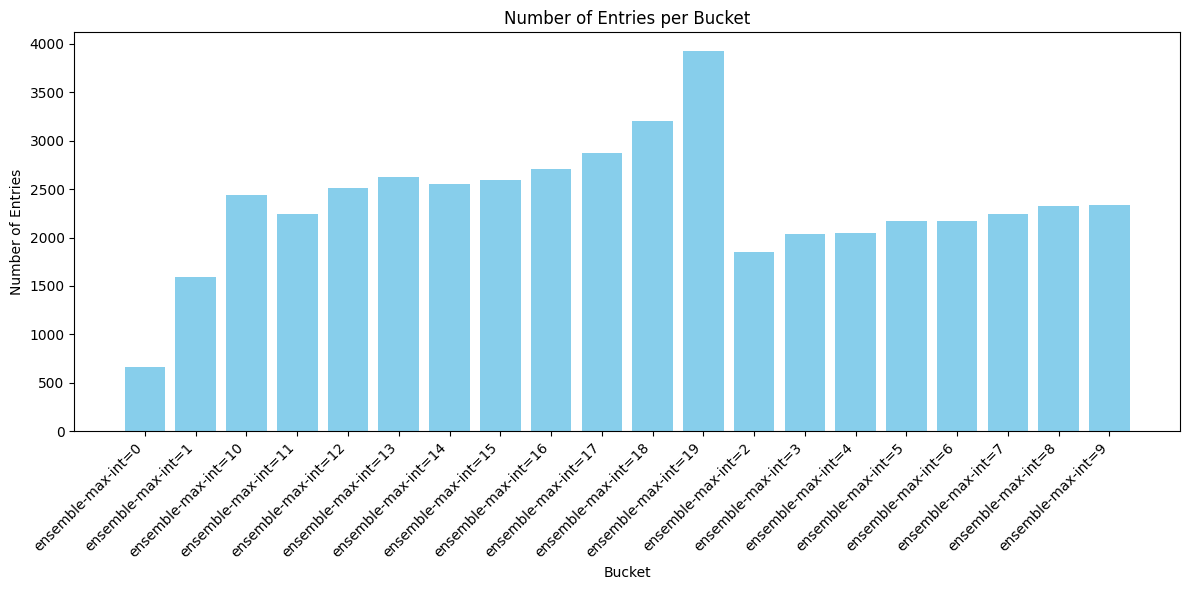

In [46]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

bucket_counts = {}
for bucket in all_buckets:
    bucket_path = os.path.join(output_bucketed_results, bucket)
    parquet_files = glob.glob(os.path.join(bucket_path, '*.parquet'))
    
    count = 0
    for file in parquet_files:
        try:
            df = pd.read_parquet(file)
            count += len(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    bucket_counts[bucket] = count

print("Number of entries in each bucket:")
print(bucket_counts)

# Create a bar plot of bucket counts
plt.figure(figsize=(12, 6))
buckets = list(bucket_counts.keys())
counts = list(bucket_counts.values())

plt.bar(buckets, counts, color='skyblue')
plt.xlabel("Bucket")
plt.ylabel("Number of Entries")
plt.title("Number of Entries per Bucket")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

This step labels the data with quality scores but does not alter the dataset size through filtering.

In [ ]:
tracker.record_size("Model quality labeling") # tracker takes the last stage's size as current stage's size when no size is provided.
tracker.print_summary()

### 3. Synthetic Data Generation

Next, we perform synthetic data generation on low-quality and high-quality data separately. 

For low-quality data, we use a Wikipedia Rephraser pipeline. This pipeline employs a medium-sized language model to generate an improved parallel corpus of synthetic data, which reduces model perplexity and increases accuracy on downstream tasks. We use the Wikipedia style prompt to rewrite low-quality documents, effectively reducing errors and redundancies while improving formatting.

#### 3.1 SDG for Low quality data

To streamline the process of identifying low-quality data, we adopt the bucket classification system outlined in the paper, eliminating the need for extensive LLM training. Based on the provided table, we designate buckets 0-11 as representative of low-quality data and buckets 12-19 as indicative of high-quality data. Feel free to adjust these ranges to suit your specific requirements.

# <img src="bucket_classification.png" alt="Bucket Classification">


In [5]:
client = get_client(cluster_type="cpu", n_workers=10, processes=True, memory_limit='16GiB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 160.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44089,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 160.00 GiB
Comm: tcp://127.0.0.1:34975,Total threads: 1
Dashboard: http://127.0.0.1:37697/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34387,


In [6]:
# input_data_path = output_bucketed_results
from openai import OpenAI
from transformers import AutoTokenizer

input_data_dir = os.path.join(data_dir, "quality_labeling", "bucketed_results")
output_data_dir = os.path.join(data_dir, "wikipedia_rephrasing", "rephrased.parquet")

openai_api_token = "<your-api-key>"
hf_token = "<your-hf-token>"
openai_client = OpenAI(base_url="https://integrate.api.nvidia.com/v1", api_key=openai_api_token)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-Nemo-Instruct-2407", token=hf_token)
api_model_name = "nvdev/nv-mistralai/mistral-nemo-12b-instruct"

# The Wikipedia rephraser calls the model via the OpenAI API client for every single entry, which can be time-consuming for large datasets. 
# For this tutorial, we will only rephrase the first few entries, as determined by `n_entries`. 
# Adjust this number based on your infrastructure. 
# If your model is deployed locally then API calls will be faster, so you can choose to process the entire dataset if you prefer.
n_entries = 5

!mkdir -p {output_data_dir}

In [7]:
## Write Code for splitting ensemble buckets into low and high quality based on your chosen threshold.
low_quality_dir = os.path.join(input_data_dir, "low_quality")
high_quality_dir = os.path.join(input_data_dir, "high_quality")

In [ ]:
from nemotron_sdg_utilities import wikipedia_rephraser

dataset = DocumentDataset.read_parquet(
        input_files=low_quality_dir,
        blocksize="1GiB",
        backend="pandas"
    )

rephrased_dataset = wikipedia_rephraser(dataset,"text",openai_client,tokenizer,api_model_name,n_entries)

Reading 1 files with blocksize='1GiB' / files_per_partition=None


Running Wikipedia rephraser preprocessing pipeline


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:455: UserWarning: If underlying Parquet data does not have a consistent column order, reading with blocksize might fail. Please use files_per_partition approach instead.
  warnings.warn(


Using only a small portion of the input dataset to save time: 
                 id                                               text  \
0  EN_CC-0000000181  OMG!!! I am so so so so so made up to see that...   
0  EN_CC-0000000909  No comments:\n\nPost a Comment\n\nREAD THIS BE...   
1  EN_CC-0000000909  COMMENTS POLICY: My blog is my house; I'm resp...   
0  EN_CC-0000001144  This item is a recurring or deferred purchase....   
0  EN_CC-0000001276  Bown of London\n\nBown Of London Salcombe Blue...   

   document_token_count  segment_id  segment_token_count  
0                   235           0                  240  
0                   528           0                  411  
1                   528           1                  157  
0                   122           0                  132  
0                   101           0                  127  


Rephrasing texts:   0%|          | 0/5 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Rephrasing texts: 100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


Running Wikipedia rephraser postprocessing pipeline
Wikipedia rephraser postprocessing complete.


In [9]:
rephrased_df = rephrased_dataset.df[["id", "rephrased"]]
dataset.df = dataset.df.merge(rephrased_df, on="id", how="left")
for index, row in dataset.df.head(n_entries).iterrows():
    print(f"Index: {row["id"]}")
    print("\n")
    print(f"Text: {row['text']}")
    print("\n")
    print(f"Rephrased: {row['rephrased']}")
    print("-" * 20)

In [15]:
dataset.to_parquet(output_data_dir, write_to_filename=False)

Writing to disk complete for 1 partition(s)


In [17]:
client.cluster.close()
client.shutdown()

#### 3.2 SDG for High quality data

For high-quality documents, we generate synthetic data using four additional SDG steps:

1.  **Diverse Question-Answer (QA) pairs:** Ask questions in various forms (e.g., yes/no, open-ended, multi-choice) about factual information in the text and provide the correct answers.
2.  **Distill:** Rewrite the text into a concise and clear passage.
3.  **Extract knowledge:** Rewrite knowledge from the text, disregarding uninformative content.
4.  **Knowledge list:** Extract key information from the text as an organized list.

The preprocessing and postprocessing pipelines for all four SDG steps are implemented as helper functions in `nemotron_sdg_utilities.py`. Review this file to understand how the pipelines are constructed using NeMo Curator.

In [5]:
# input_data_path = output_bucketed_results
from openai import OpenAI
from transformers import AutoTokenizer

input_data_dir = os.path.join(data_dir, "quality_labeling", "bucketed_results")
high_quality_dir = os.path.join(input_data_dir,"high_quality")
output_data_dir = os.path.join(data_dir, "high_sdg")

openai_api_token = "<your-api-key>"
hf_token = "<your-hf-key>"
openai_client = OpenAI(base_url="https://integrate.api.nvidia.com/v1", api_key=openai_api_token)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-Nemo-Instruct-2407", token=hf_token)
api_model_name = "nvdev/nv-mistralai/mistral-nemo-12b-instruct"

# The Wikipedia rephraser calls the model via the OpenAI API client for every single entry, which can be time-consuming for large datasets. 
# For this tutorial, we will only rephrase the first few entries, as determined by `n_entries`. 
# Adjust this number based on your infrastructure. 
# If your model is deployed locally then API calls will be faster, so you can choose to process the entire dataset if you prefer.
n_entries = 5

!mkdir -p {output_data_dir}

In [6]:
from nemotron_sdg_utilities import diverse_qa, distill, extract_knowledge, knowledge_list

dataset = DocumentDataset.read_parquet(
        input_files=os.path.join(high_quality_dir,"ensemble-max-int=12_part.0.parquet"),
        blocksize="1GiB",
        backend="pandas"
    )

dataset.head(n_entries)

Reading 1 files with blocksize='1GiB' / files_per_partition=None


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:455: UserWarning: If underlying Parquet data does not have a consistent column order, reading with blocksize might fail. Please use files_per_partition approach instead.
  warnings.warn(


,fasttext-quality-score,fasttext-quality-score-int,fineweb-mixtral-edu-score,fineweb-mixtral-edu-score-int,fineweb-mixtral-edu-score-label,fineweb-nemotron-edu-score,fineweb-nemotron-edu-score-int,fineweb-nemotron-edu-score-label,id,language,source_id,text,url,warc_id
0,0.000377,2,1.568359,11,low_quality,1.768555,12,low_quality,EN_CC-0000000048,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,This is an initiative of NOVA ZAGORA associati...,http://children-art.org/en/art-life-en/contest...,6d5e9ea0-3d76-4306-b538-a0ca65bda444
1,0.020293,12,0.859863,6,low_quality,1.063477,6,low_quality,EN_CC-0000000102,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,CitruSlim – CitruSlim\n\nAll orders are protec...,http://fordjoursfamilyhealthproducts.com/2022/...,69f82700-aae5-4c2d-866c-79b0adc16742
2,0.000751,3,1.672852,12,low_quality,1.779297,12,low_quality,EN_CC-0000000113,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,NAME\nMaypole - MVC web application framework\...,http://ftp.jaist.ac.jp/pub/CPAN/modules/by-mod...,75881d14-2aa8-426b-aa4c-4bd06d972cf9
3,0.000015,0,1.269531,9,low_quality,1.761719,12,low_quality,EN_CC-0000000115,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,E.J. Gold's JazzArt Scrapbook\n\nInquire for a...,http://gatewaysbooksandtapes.com/books/bk278.html,092dfc1b-d71d-4498-8623-2e72fe91d0fb
4,0.004947,8,1.423828,10,low_quality,1.743164,12,low_quality,EN_CC-0000000117,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Tour\n\nWelcome\n\nWelcome to this brief tour ...,http://geniushospitality.co.uk.nutriplannerdev...,2cc9d2b4-7770-45de-921c-a60ad1d8b01d


In [7]:
diverseqa_dataset = diverse_qa(dataset,"text",openai_client,tokenizer,api_model_name,n_entries)
distilled_dataset = distill(dataset,"text",openai_client,tokenizer,api_model_name,n_entries)
extract_knowledge_dataset = extract_knowledge(dataset,"text",openai_client,tokenizer,api_model_name,n_entries)
knowledget_list_dataset = knowledge_list(dataset,"text",openai_client,tokenizer,api_model_name,n_entries)

Running DiverseQA preprocessing pipeline
Taking out a small portion of the input dataset to save time.


Querying LLM..:   0%|          | 0/5 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Querying LLM..: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]


Running DiverseQA postprocessing pipeline
DiverseQA generation complete.
Merging results with original dataset.
Writing to disk complete for 1 partition(s)
Running Distill preprocessing pipeline
Taking out a small portion of the input dataset to save time.


Querying LLM..:   0%|          | 0/5 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Querying LLM..: 100%|██████████| 5/5 [00:30<00:00,  6.08s/it]


Running Distill postprocessing pipeline
Distill postprocessing pipeline complete.
Merging results with original dataset.
Writing to disk complete for 1 partition(s)
Running extract knowledge preprocessing pipeline
Taking out a small portion of the input dataset to save time.


Querying LLM..:   0%|          | 0/5 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Querying LLM..: 100%|██████████| 5/5 [00:42<00:00,  8.50s/it]


Running extract knowledge postprocessing pipeline
Extract knowledge generation complete.
Extract knowledge results: 
Writing to disk complete for 1 partition(s)
Running Knowledge list preprocessing pipeline
Taking out a small portion of the input dataset to save time.


Querying LLM..:   0%|          | 0/5 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Querying LLM..: 100%|██████████| 5/5 [00:35<00:00,  7.02s/it]


Running Knowledge list postprocessing pipeline
Knowledge list generation complete.
Knowledge list results: 
Merging results with original dataset.
Writing to disk complete for 1 partition(s)


In [8]:
dataset.df = dataset.df.merge(
    diverseqa_dataset.df[["id", "llm_response"]], 
    on="id", 
    how="left", 
)
dataset.df = dataset.df.rename(columns={"llm_response": "diverseqa"})
dataset.df = dataset.df.merge(
    distilled_dataset.df[["id", "llm_response"]], 
    on="id", 
    how="left", 
)
dataset.df = dataset.df.rename(columns={"llm_response": "distill"})
dataset.df = dataset.df.merge(
    extract_knowledge_dataset.df[["id", "llm_response"]], 
    on="id", 
    how="left", 
)
dataset.df = dataset.df.rename(columns={"llm_response": "extract"})
dataset.df = dataset.df.merge(
    knowledget_list_dataset.df[["id", "llm_response"]], 
    on="id", 
    how="left", 
)
dataset.df = dataset.df.rename(columns={"llm_response": "knowledge"})
dataset.df.head()

,fasttext-quality-score,fasttext-quality-score-int,fineweb-mixtral-edu-score,fineweb-mixtral-edu-score-int,fineweb-mixtral-edu-score-label,fineweb-nemotron-edu-score,fineweb-nemotron-edu-score-int,fineweb-nemotron-edu-score-label,id,language,source_id,text,url,warc_id,document_token_count,diverseqa,distill,extract,knowledge
0,0.000377,2,1.568359,11,low_quality,1.768555,12,low_quality,EN_CC-0000000048,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,This is an initiative of NOVA ZAGORA associati...,http://children-art.org/en/art-life-en/contest...,6d5e9ea0-3d76-4306-b538-a0ca65bda444,132,This is an initiative of NOVA ZAGORA associati...,"The ""Ears and Paws"" exhibition is an annual ev...","Nova Zagora Art Exhibition\n\nEvery year, the ...",Organizers:\n- NOVA ZAGORA association\n- DUGA...
1,0.020293,12,0.859863,6,low_quality,1.063477,6,low_quality,EN_CC-0000000102,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,CitruSlim – CitruSlim\n\nAll orders are protec...,http://fordjoursfamilyhealthproducts.com/2022/...,69f82700-aae5-4c2d-866c-79b0adc16742,2995,CitruSlim – CitruSlim\n\nAll orders are protec...,"CitruSlim™ offers a 60-day, no-questions-asked...",CitruSlim: A Novel Approach to Weight Manageme...,Product Information:\n- Product Name: CitruSli...
2,0.020293,12,0.859863,6,low_quality,1.063477,6,low_quality,EN_CC-0000000102,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,CitruSlim – CitruSlim\n\nAll orders are protec...,http://fordjoursfamilyhealthproducts.com/2022/...,69f82700-aae5-4c2d-866c-79b0adc16742,2995,CitruSlim – CitruSlim\n\nAll orders are protec...,"CitruSlim™ offers a 60-day, no-questions-asked...",CitruSlim: A Novel Approach to Weight Manageme...,"Stress Levels: Modern-day life is stressful, w..."
3,0.020293,12,0.859863,6,low_quality,1.063477,6,low_quality,EN_CC-0000000102,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,CitruSlim – CitruSlim\n\nAll orders are protec...,http://fordjoursfamilyhealthproducts.com/2022/...,69f82700-aae5-4c2d-866c-79b0adc16742,2995,CitruSlim – CitruSlim\n\nAll orders are protec...,"CitruSlim™ offers a 60-day, no-questions-asked...",CitruSlim: A Novel Approach to Weight Manageme...,Product Name: CitruSlim®\nDevelopment:\n- Deve...
4,0.020293,12,0.859863,6,low_quality,1.063477,6,low_quality,EN_CC-0000000102,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,CitruSlim – CitruSlim\n\nAll orders are protec...,http://fordjoursfamilyhealthproducts.com/2022/...,69f82700-aae5-4c2d-866c-79b0adc16742,2995,CitruSlim – CitruSlim\n\nAll orders are protec...,"CitruSlim™ offers a 60-day, no-questions-asked...",CitruSlim: A Novel Approach to Weight Manageme...,"Product: CitruSlim®, a weight management suppl..."


In [9]:

dataset.to_parquet(os.path.join(output_data_dir,"result.parquet"))

Writing to disk complete for 1 partition(s)


In [10]:
final_df = pd.read_parquet(os.path.join(output_data_dir,"result.parquet"))
final_df

,fasttext-quality-score,fasttext-quality-score-int,fineweb-mixtral-edu-score,fineweb-mixtral-edu-score-int,fineweb-mixtral-edu-score-label,fineweb-nemotron-edu-score,fineweb-nemotron-edu-score-int,fineweb-nemotron-edu-score-label,id,language,source_id,text,url,warc_id,document_token_count,diverseqa,distill,extract,knowledge
0,0.000377,2,1.568359,11,low_quality,1.768555,12,low_quality,EN_CC-0000000048,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,This is an initiative of NOVA ZAGORA associati...,http://children-art.org/en/art-life-en/contest...,6d5e9ea0-3d76-4306-b538-a0ca65bda444,132,This is an initiative of NOVA ZAGORA associati...,"The ""Ears and Paws"" exhibition is an annual ev...","Nova Zagora Art Exhibition\n\nEvery year, the ...",Organizers:\n- NOVA ZAGORA association\n- DUGA...
1,0.020293,12,0.859863,6,low_quality,1.063477,6,low_quality,EN_CC-0000000102,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,CitruSlim – CitruSlim\n\nAll orders are protec...,http://fordjoursfamilyhealthproducts.com/2022/...,69f82700-aae5-4c2d-866c-79b0adc16742,2995,CitruSlim – CitruSlim\n\nAll orders are protec...,"CitruSlim™ offers a 60-day, no-questions-asked...",CitruSlim: A Novel Approach to Weight Manageme...,Product Information:\n- Product Name: CitruSli...
2,0.020293,12,0.859863,6,low_quality,1.063477,6,low_quality,EN_CC-0000000102,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,CitruSlim – CitruSlim\n\nAll orders are protec...,http://fordjoursfamilyhealthproducts.com/2022/...,69f82700-aae5-4c2d-866c-79b0adc16742,2995,CitruSlim – CitruSlim\n\nAll orders are protec...,"CitruSlim™ offers a 60-day, no-questions-asked...",CitruSlim: A Novel Approach to Weight Manageme...,"Stress Levels: Modern-day life is stressful, w..."
3,0.020293,12,0.859863,6,low_quality,1.063477,6,low_quality,EN_CC-0000000102,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,CitruSlim – CitruSlim\n\nAll orders are protec...,http://fordjoursfamilyhealthproducts.com/2022/...,69f82700-aae5-4c2d-866c-79b0adc16742,2995,CitruSlim – CitruSlim\n\nAll orders are protec...,"CitruSlim™ offers a 60-day, no-questions-asked...",CitruSlim: A Novel Approach to Weight Manageme...,Product Name: CitruSlim®\nDevelopment:\n- Deve...
4,0.020293,12,0.859863,6,low_quality,1.063477,6,low_quality,EN_CC-0000000102,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,CitruSlim – CitruSlim\n\nAll orders are protec...,http://fordjoursfamilyhealthproducts.com/2022/...,69f82700-aae5-4c2d-866c-79b0adc16742,2995,CitruSlim – CitruSlim\n\nAll orders are protec...,"CitruSlim™ offers a 60-day, no-questions-asked...",CitruSlim: A Novel Approach to Weight Manageme...,"Product: CitruSlim®, a weight management suppl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,0.009444,9,1.374023,10,low_quality,1.690430,12,low_quality,EN_CC-0000073941,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,HR Specialist\nThe Judge Group Inc.\n\nJob Inf...,https://www.veteranjobcenter.com/jobs/hr-speci...,329bdee4-c9a6-45da-b569-dbea52fbee75,323,None,None,None,None
2601,0.021839,12,1.532227,11,low_quality,1.088867,7,low_quality,EN_CC-0000073986,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,"Punta Gorda, Florida Water Mitigation Service\...",https://www.watermitigationpros.com/near-me/pu...,0732d48e-894c-4e7f-a497-545f7af3943d,1243,None,None,None,None
2602,0.020732,12,0.569336,4,low_quality,0.310791,1,low_quality,EN_CC-0000074026,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,(The colours shown are for illustrative purpos...,https://www.wickydeez.com/products/red-panda-b...,5b8c4225-d4c1-46d7-8949-bf56e8f089be,593,None,None,None,None
2603,0.000253,1,0.876465,6,low_quality,1.748047,12,low_quality,EN_CC-0000074101,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Schedule your private session(s) or register f...,https://www.yourinspiredjourney.com/book-onilne,e5591ea5-c3cd-4561-b4ff-2bae603fe84b,506,None,None,None,None
